## Model load

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import load_model

unet_model = load_model('./U_D_model/unet.h5')
disc_model = load_model('./U_D_model/discriminator.h5')

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## MNIST 전처리

In [2]:
# MNIST Load Normalization
(_, _), (x_test, y_label) = mnist.load_data()
y_test = x_test[:1000].astype('float32') / 255. 

y_test = y_test.reshape((y_test.shape[0],28,28,1)) # Origin MNIST
x_test = y_test.copy()  # Noise MNIST
y_label = y_label[:1000].copy() # label 

# noise range
rn = 5

# Random broken MNIST make 
for i in range(0, x_test.shape[0]) : 
    ix = np.random.randint(0, x_test.shape[1]-rn)
    iz = np.random.randint(0, x_test.shape[1]-rn)
    ic = np.random.randint(0, x_test.shape[1]-rn)
    x_test[i, 10:20, ix:ix+rn] = 1.
    x_test[i, iz:iz+rn , 5:14] = 1.
    x_test[i, ic:ic+rn , ic:ic+rn] = 1.

## Image prediction

In [3]:
def anomaly(x_test) :
    
    generated = unet_model.predict(x_test)
    dicriminated = disc_model.predict(generated)

    diff = x_test - generated
    diff = diff.reshape((diff.shape[0],)+(28,28))
    diff = np.stack((diff,)*3, -1) # 3채널 배열로 변경
    
    data, rows, cols, channels = diff.shape

    # 전체 데이터 rosw, cols, channels 순회
    for a in range(data) : 
        for i in range(rows):
            for j in range(cols):
                if diff[a,i, j, 0] == 1 :
                    diff[a, i, j, 0] = 255

        for i in range(rows):
            for j in range(cols):
                if diff[a, i, j, 1] == 1 :
                    diff[a, i, j, 1] = 0

        for i in range(rows):
            for j in range(cols):
                if diff[a, i, j, 2] == 1 :
                    diff[a, i, j, 2] = 0 

    return (diff, generated, dicriminated)

anomaly, generated, dicriminated = anomaly(x_test)

## Image 시각화

input Image (noise MNIST)

Origin MNIST  

Generated Image (UNET)

Anomaly Image (diff = noise - Generated)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


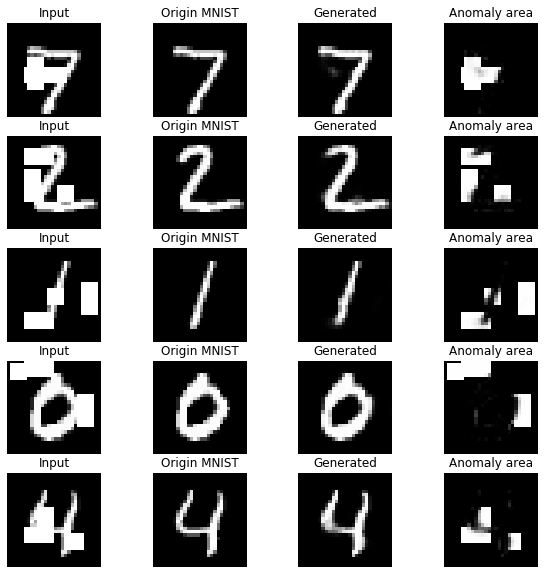

In [6]:
fig, axs = plt.subplots(5, 4 ,figsize=(10,10))

for i in range(5) :
    # fig.suptitle('y_test & Broken_MNIST & unet_predicted' , fontsize=14)
    axs[i, 0].set_axis_off()
    axs[i, 0].set_title('Input')
    axs[i, 0].imshow(x_test[i].reshape(28,28), cmap='gray')

    axs[i, 1].set_axis_off()
    # axs[i, 1].set_title('y_label: %.f' % (y_label[i]))
    axs[i, 1].set_title('Origin MNIST')
    axs[i, 1].imshow(y_test[i].reshape(28,28), cmap='gray')

    axs[i, 2].set_axis_off()
    # axs[i, 2].set_title('dicriminated: %.1f' % (dicriminated[i]))
    axs[i, 2].set_title('Generated')
    axs[i, 2].imshow(generated[i].reshape(28,28), cmap='gray')

    axs[i, 3].set_axis_off()
    axs[i, 3].set_title('Anomaly area') 
    axs[i, 3].imshow(anomaly[i])
    
plt.show()
plt.close(fig)

## Discriminated

Generated Iamge를 판별할때 모두 Real(진짜 MNIST)로 판별의 분포 확인

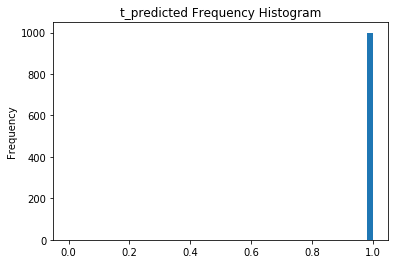

In [5]:
plt.hist(dicriminated, bins=50, range=(0,1))
plt.gca().set(title='t_predicted Frequency Histogram', ylabel='Frequency')
plt.show()
plt.close()